In [97]:
import numpy as np
import pandas as pd
import psutil
from pandarallel import pandarallel
from tqdm.auto import tqdm
from typing import Iterable
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn as nn
import torch

import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from torcheval.metrics.functional import multiclass_f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [98]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/tmp/data/"
MODELS_DIR = "/content/drive/MyDrive/tmp/models/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
torch_device = torch.device("cuda:0")
print(f"Девайс: {torch_device}.")

Девайс: cuda:0.


In [100]:
print('Количество доступных потоков: ', psutil.cpu_count(logical=False))

Количество доступных потоков:  1


# Предобработка датасета

In [101]:
dataset = pd.read_csv(f"{DATA_DIR}Data_Sources.csv", sep=";", encoding="UTF-8")
dataset

,url,date,text,tag,source
0,https://vk.com/club3291025?w=wall-3291025_1020782,2023-04-15 19:39,Всем добрый день! У меня БАР 2 типа. Начала ч...,БАР,ВК
1,https://vk.com/id32362343,2023-04-15 19:46,это на всякий случай?,БАР,ВК
2,https://vk.com/id415411329,2023-04-15 19:44,Попробуйте успокоиться. Сделайте выводы. Приго...,БАР,ВК
3,https://vk.com/id777797099,2023-04-15 19:44,На все вопросы вы ответили сами.,БАР,ВК
4,https://vk.com/id739587393,2023-04-15 19:47,"Всё к лучшему. Если вы так сделали, значит так...",БАР,ВК
...,...,...,...,...,...
66455,https://vk.com/id19312999,2019-04-02 9:03,https://pcixi.ru/forum/88-9302-1 Исцеление люб...,шизофрения,ВК
66456,https://vk.com/id19312999,2019-04-02 10:35,не лечится анамалия развития? То есть если я с...,шизофрения,ВК
66457,https://vk.com/id19312999,2019-04-02 18:31,"благодарю за ответ. Спасибо, я почитаю про шиз...",шизофрения,ВК
66458,https://vk.com/id293789448,2019-04-02 22:17,"в церковь ходили, батюшка лет 20 назад очень п...",шизофрения,ВК


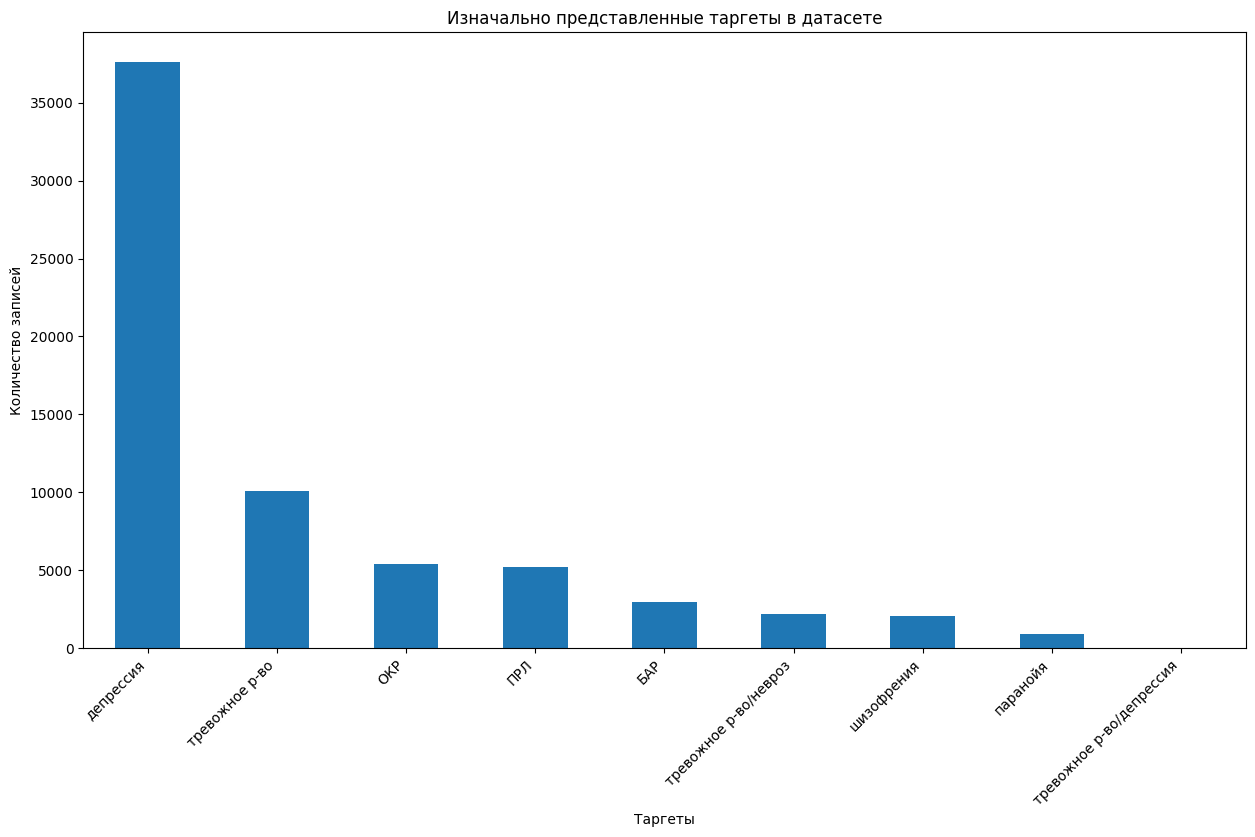

In [102]:
plt.figure(figsize=(15,8))
dataset["tag"].value_counts().plot.bar()
plt.xticks(rotation=45, ha='right')
plt.title("Изначально представленные таргеты в датасете")
plt.xlabel("Таргеты")
plt.ylabel("Количество записей")
plt.show()

In [103]:
dataset["tag"].replace("тревожное р-во/депрессия", "тревожное р-во", inplace=True)
dataset["tag"].replace("тревожное р-во/невроз", "тревожное р-во", inplace=True)
dataset["tag"].replace("паранойя", None, inplace=True)
dataset.dropna(axis=0, inplace=True)

dataset.drop(labels=["url", "date", "source"], axis=1, inplace=True)

dataset

,text,tag
0,Всем добрый день! У меня БАР 2 типа. Начала ч...,БАР
1,это на всякий случай?,БАР
2,Попробуйте успокоиться. Сделайте выводы. Приго...,БАР
3,На все вопросы вы ответили сами.,БАР
4,"Всё к лучшему. Если вы так сделали, значит так...",БАР
...,...,...
66455,https://pcixi.ru/forum/88-9302-1 Исцеление люб...,шизофрения
66456,не лечится анамалия развития? То есть если я с...,шизофрения
66457,"благодарю за ответ. Спасибо, я почитаю про шиз...",шизофрения
66458,"в церковь ходили, батюшка лет 20 назад очень п...",шизофрения


In [104]:
tokens_distribution = {}

dataset["text"] = dataset["text"].apply(lambda text: word_tokenize(text, language="russian"))
for target_value in dataset["tag"].unique():
    tokens_distribution[target_value] = {}
    for sequence in dataset[dataset["tag"] == target_value]["text"]:
        for token in sequence:
            if token in tokens_distribution[target_value].keys():
                tokens_distribution[target_value][token] += 1
            else:
                tokens_distribution[target_value][token] = 1
tokens_distribution = pd.DataFrame(tokens_distribution)
tokens_distribution.fillna(0, inplace=True)

tokens_distribution

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,7.0,45.0,9.0,14.0,19.0,3.0
добрый,6.0,129.0,17.0,17.0,42.0,6.0
день,94.0,1538.0,230.0,127.0,713.0,43.0
!,642.0,6089.0,785.0,838.0,1967.0,431.0
У,178.0,2101.0,305.0,302.0,639.0,144.0
...,...,...,...,...,...,...
незанятым,0.0,0.0,0.0,0.0,0.0,1.0
выметенным,0.0,0.0,0.0,0.0,0.0,1.0
убранным,0.0,0.0,0.0,0.0,0.0,1.0
злейших,0.0,0.0,0.0,0.0,0.0,1.0


In [105]:
tokens_distribution = tokens_distribution[tokens_distribution.sum(axis=1) > 20]
tokens_distribution

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,7.0,45.0,9.0,14.0,19.0,3.0
добрый,6.0,129.0,17.0,17.0,42.0,6.0
день,94.0,1538.0,230.0,127.0,713.0,43.0
!,642.0,6089.0,785.0,838.0,1967.0,431.0
У,178.0,2101.0,305.0,302.0,639.0,144.0
...,...,...,...,...,...,...
тонометр,0.0,0.0,0.0,0.0,25.0,0.0
Соня,0.0,0.0,0.0,0.0,31.0,0.0
тонометра,0.0,0.0,0.0,0.0,38.0,0.0
МП,0.0,0.0,0.0,0.0,29.0,0.0


In [106]:
target_count = dataset["tag"].value_counts()
for target_value in tokens_distribution.columns:
    tokens_distribution[target_value] = tokens_distribution[target_value] / target_count[target_value]

tokens_distribution

<ipython-input-106-251b3fc6598b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokens_distribution[target_value] = tokens_distribution[target_value] / target_count[target_value]


,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,0.002505,0.001201,0.001745,0.002683,0.001546,0.001460
добрый,0.002147,0.003442,0.003296,0.003257,0.003418,0.002920
день,0.033644,0.041041,0.044591,0.024334,0.058029,0.020925
!,0.229778,0.162482,0.152191,0.160567,0.160088,0.209732
У,0.063708,0.056064,0.059131,0.057865,0.052006,0.070073
...,...,...,...,...,...,...
тонометр,0.000000,0.000000,0.000000,0.000000,0.002035,0.000000
Соня,0.000000,0.000000,0.000000,0.000000,0.002523,0.000000
тонометра,0.000000,0.000000,0.000000,0.000000,0.003093,0.000000
МП,0.000000,0.000000,0.000000,0.000000,0.002360,0.000000


In [107]:
stop_words = stopwords.words('russian')
other_stop_words = [",", ".", "...", "?", "!", ":", "-", "(", ")", "``", "''", "Я", "Вы", "это", "И", "А", "Но", "очень", "просто", "нужно"]
for add_stop in other_stop_words:
    stop_words.append(add_stop)

tokens_distribution.loc[[token for token in stop_words if token in tokens_distribution.index]]

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
и,1.186113,1.359706,1.526367,1.260970,1.554651,1.340633
в,0.852899,0.959733,1.044397,0.889634,1.124440,0.918248
во,0.024696,0.032128,0.039550,0.029891,0.035647,0.023844
не,0.957767,1.104043,1.283637,1.063039,1.138602,1.217032
что,0.631711,0.795464,0.990694,0.779843,0.844795,0.674453
...,...,...,...,...,...,...
А,0.130995,0.137852,0.174486,0.151370,0.170261,0.171776
Но,0.094488,0.097612,0.153742,0.125695,0.118825,0.102676
очень,0.100573,0.117759,0.121753,0.141406,0.132986,0.103650
просто,0.061918,0.099320,0.121753,0.096762,0.097990,0.092457


In [108]:
tokens_distribution = tokens_distribution.loc[[token for token in tokens_distribution.index if token not in stop_words]]
tokens_distribution

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,0.002505,0.001201,0.001745,0.002683,0.001546,0.001460
добрый,0.002147,0.003442,0.003296,0.003257,0.003418,0.002920
день,0.033644,0.041041,0.044591,0.024334,0.058029,0.020925
У,0.063708,0.056064,0.059131,0.057865,0.052006,0.070073
БАР,0.077309,0.001094,0.000000,0.002683,0.000326,0.000487
...,...,...,...,...,...,...
тонометр,0.000000,0.000000,0.000000,0.000000,0.002035,0.000000
Соня,0.000000,0.000000,0.000000,0.000000,0.002523,0.000000
тонометра,0.000000,0.000000,0.000000,0.000000,0.003093,0.000000
МП,0.000000,0.000000,0.000000,0.000000,0.002360,0.000000


In [109]:
tokens_distribution = tokens_distribution[tokens_distribution.max(axis=1) > 0.001]
tokens_distribution

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,0.002505,0.001201,0.001745,0.002683,0.001546,0.001460
добрый,0.002147,0.003442,0.003296,0.003257,0.003418,0.002920
день,0.033644,0.041041,0.044591,0.024334,0.058029,0.020925
У,0.063708,0.056064,0.059131,0.057865,0.052006,0.070073
БАР,0.077309,0.001094,0.000000,0.002683,0.000326,0.000487
...,...,...,...,...,...,...
тонометр,0.000000,0.000000,0.000000,0.000000,0.002035,0.000000
Соня,0.000000,0.000000,0.000000,0.000000,0.002523,0.000000
тонометра,0.000000,0.000000,0.000000,0.000000,0.003093,0.000000
МП,0.000000,0.000000,0.000000,0.000000,0.002360,0.000000


In [110]:
important_tokens = []

for index, row in tokens_distribution.iterrows():
    if row.max() - row.mean() > 0.015:
        important_tokens.append(index)

In [111]:
tokens_distribution.loc[important_tokens].idxmax(axis=1).value_counts()

шизофрения        22
тревожное р-во    14
ОКР               14
ПРЛ               13
депрессия          5
БАР                4
Name: count, dtype: int64

In [112]:
for index, row in tokens_distribution.iterrows():
    new_row = np.exp(row)/np.sum(np.exp(row))
    tokens_distribution.loc[index] = np.exp(row)/np.sum(np.exp(row))
tokens_distribution

,БАР,депрессия,ОКР,ПРЛ,тревожное р-во,шизофрения
Всем,0.166775,0.166557,0.166648,0.166804,0.166615,0.166601
добрый,0.166511,0.166727,0.166703,0.166696,0.166723,0.166640
день,0.166080,0.167313,0.167908,0.164541,0.170179,0.163981
У,0.167315,0.166041,0.166551,0.166340,0.165369,0.168384
БАР,0.177548,0.164519,0.164339,0.164781,0.164393,0.164419
...,...,...,...,...,...,...
тонометр,0.166610,0.166610,0.166610,0.166610,0.166949,0.166610
Соня,0.166597,0.166597,0.166597,0.166597,0.167017,0.166597
тонометра,0.166581,0.166581,0.166581,0.166581,0.167097,0.166581
МП,0.166601,0.166601,0.166601,0.166601,0.166995,0.166601


In [113]:
class_tokens = {}
for label in tokens_distribution.columns:
    class_tokens[label] = list(tokens_distribution.loc[important_tokens][label].nlargest(15).index)

In [114]:
for label in tokens_distribution.columns:
    for index, row in dataset[dataset["tag"] == label].iterrows():
        if not any(token in row["text"] for token in class_tokens[label]):
            dataset["text"][index] = None

dataset.dropna(axis=0, inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [115]:
pandarallel.initialize(progress_bar=True)

def clear_data(df: pd.DataFrame, stop_words: Iterable=[], important_tokens: Iterable=[], min_tokens: int = 1) -> pd.DataFrame:
    df["tag"] = df["tag"].parallel_apply(lambda text: text.upper())
    if len(important_tokens) > 0:
        df["text"] = df["text"].parallel_apply(lambda sequence: sequence if any(token in sequence for token in important_tokens) else [])
    else:
        df["text"] = df["text"].parallel_apply(lambda sequence: [word for word in sequence if word not in stop_words])
    df["text"] = df["text"].parallel_apply(lambda sequence: sequence if len(sequence) >= min_tokens else None)
    df.dropna(axis=0, inplace=True)

    df["text"] = df["text"].parallel_apply(lambda sequence: " ".join(sequence))
    df.reset_index(drop=True, inplace=True)

    return df

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [116]:
dataset = clear_data(df=dataset.copy(), important_tokens=important_tokens, min_tokens=1)
dataset

,text,tag
0,Всем добрый день ! У меня БАР 2 типа . Начала ...,БАР
1,вы серьезно ? Алкоголизм это к лучшему ? Вас с...,БАР
2,Лучше сменить фармакотерапию и продолжить лече...,БАР
3,"Приветствую вас . Это очень трудная ситуация ,...",БАР
4,это вы сейчас человеку с БАР такой бред будете...,БАР
...,...,...
20889,"если голоса слышит , есть бред , то это не про...",ШИЗОФРЕНИЯ
20890,шизофрения не всегда становится все хуже и хуж...,ШИЗОФРЕНИЯ
20891,"благодарю за ответ. Спасибо , я почитаю про ши...",ШИЗОФРЕНИЯ
20892,"в церковь ходили , батюшка лет 20 назад очень ...",ШИЗОФРЕНИЯ


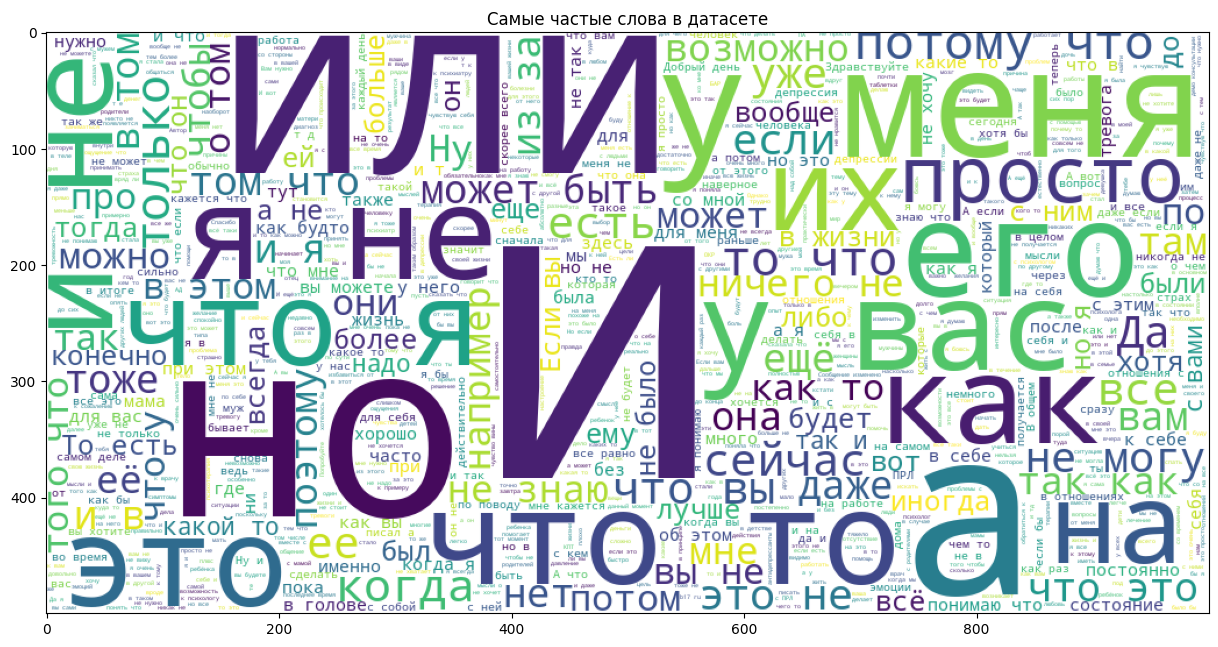

In [117]:
wordcloud = WordCloud(background_color='white', max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500, random_state=42)
wordcloud.generate(" ".join(dataset["text"]))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.title("Самые частые слова в датасете")
plt.show()

In [118]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny-toxicity")
tokenizer

BertTokenizerFast(name_or_path='cointegrated/rubert-tiny-toxicity', vocab_size=29564, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [119]:
vocab_len = len(tokenizer.vocab)

In [120]:
word2id = {}
id2word = {}
for word, id in tokenizer.vocab.items():
    word2id[word] = id
    id2word[id] = word

In [121]:
encoded_data = tokenizer(dataset["text"].tolist(), max_length=100, return_tensors="np", truncation=True, padding=True)

In [122]:
data_X = pd.DataFrame(columns=encoded_data.keys())
for key in encoded_data.keys():
    data_X[key] = encoded_data[key].tolist()

In [123]:
data_y = pd.get_dummies(dataset["tag"], dtype=float)
labels = data_y.columns

In [124]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=42, stratify=data_y, shuffle=True)

In [125]:
input_size = len(X_train["input_ids"].iloc[0])
target_size = y_train.shape[1]

In [126]:
model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny-toxicity" )
model.classifier = nn.Linear(in_features=312, out_features=target_size, bias=True)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-1

In [127]:
for p in model.parameters():
    p.requires_grad = True

In [128]:
class CustomDataset(Dataset):
    def __init__(self, X, Y, device):
        self.device = device
        self.input_ids = torch.stack([torch.tensor(seq, dtype=torch.int32) for seq in X["input_ids"]])
        self.attention_mask = torch.stack([torch.tensor(seq, dtype=torch.int32) for seq in X["attention_mask"]])
        self.labels = torch.tensor(Y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx].to(self.device),
            'attention_mask': self.attention_mask[idx].to(self.device),
            'label': self.labels[idx].to(self.device)
        }


def collate_batch(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'label': torch.stack([item['label'] for item in batch])
    }

In [129]:
model.to(torch_device)

dataset_train = CustomDataset(X_train, y_train, torch_device)
dataset_test = CustomDataset(X_test, y_test, torch_device)

loader_train = DataLoader(dataset=dataset_train,
                          batch_size=50,
                          collate_fn=collate_batch,
                          shuffle=True,
                         )
loader_test = DataLoader(dataset=dataset_test,
                         batch_size=50,
                         collate_fn=collate_batch,
                         shuffle=False,
                        )

In [130]:
loss_func = nn.CrossEntropyLoss(reduction="mean")

In [131]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [132]:
def train(model, loader, loss_func, optimizer) -> tuple:
    model.train()
    total_loss = 0.0
    y_preds = []
    y_trues = []

    for batch in tqdm(loader):
        input_ids, attention_mask, y_true = batch['input_ids'], batch['attention_mask'], batch['label']
        optimizer.zero_grad()
        y_pred = model(input_ids, attention_mask).logits

        loss = loss_func(y_pred, y_true.argmax(dim=1))

        loss.backward()
        optimizer.step()

        y_preds.append(nn.Softmax(dim=1)(y_pred))
        y_trues.append(y_true)

        total_loss += loss.item()
    avg_loss = total_loss / len(loader)

    y_preds = torch.cat(y_preds)
    y_trues = torch.cat(y_trues)
    labels_pred = y_preds.argmax(dim=1)
    labels_true = y_trues.argmax(dim=1)

    f_score = multiclass_f1_score(labels_pred, labels_true, num_classes=y_trues.shape[1], average="macro").item()
    accuracy = (labels_pred == labels_true).sum().item() / labels_true.shape[0]

    return avg_loss, f_score, accuracy

In [133]:
def test(model, loader, loss_func) -> tuple:
    model.eval()
    total_loss = 0.0
    y_preds = []
    y_trues = []

    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids, attention_mask, y_true = batch['input_ids'], batch['attention_mask'], batch['label']
            y_pred = model(input_ids, attention_mask).logits

            loss = loss_func(y_pred, y_true.argmax(dim=1))

            y_preds.append(nn.Softmax(dim=1)(y_pred))
            y_trues.append(y_true)

            total_loss += loss.item()
    avg_loss = total_loss / len(loader)

    y_preds = torch.cat(y_preds)
    y_trues = torch.cat(y_trues)
    labels_pred = y_preds.argmax(dim=1)
    labels_true = y_trues.argmax(dim=1)

    f_score = multiclass_f1_score(labels_pred, labels_true, num_classes=y_trues.shape[1], average="macro").item()
    accuracy = (labels_pred == labels_true).sum().item() / labels_true.shape[0]

    return avg_loss, f_score, accuracy

In [134]:
time_start = time.time()
for epoch in range(100):
    train_loss, train_f_score, train_accuracy = train(model, loader_train, loss_func, optimizer)
    test_loss, test_f_score, test_accuracy = test(model, loader_test, loss_func)
    print(f"Epoch {epoch+1}/{100}: Train Loss: {train_loss:.4f}, Train F-score: {train_f_score:.2f}, Train Accuracy: {train_accuracy:.2%}, Test Loss: {test_loss:.4f}, Test F-score: {test_f_score:.2f}, Test Accuracy: {test_accuracy:.2%}")

  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 1/100: Train Loss: 0.9681, Train F-score: 0.43, Train Accuracy: 68.28%, Test Loss: 0.7798, Test F-score: 0.57, Test Accuracy: 73.63%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 2/100: Train Loss: 0.6633, Train F-score: 0.64, Train Accuracy: 77.74%, Test Loss: 0.6825, Test F-score: 0.63, Test Accuracy: 77.43%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 3/100: Train Loss: 0.5303, Train F-score: 0.72, Train Accuracy: 82.04%, Test Loss: 0.6975, Test F-score: 0.64, Test Accuracy: 76.33%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 4/100: Train Loss: 0.4093, Train F-score: 0.79, Train Accuracy: 86.26%, Test Loss: 0.7464, Test F-score: 0.64, Test Accuracy: 75.74%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 5/100: Train Loss: 0.2959, Train F-score: 0.86, Train Accuracy: 90.50%, Test Loss: 0.8168, Test F-score: 0.64, Test Accuracy: 75.64%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 6/100: Train Loss: 0.2221, Train F-score: 0.90, Train Accuracy: 92.90%, Test Loss: 0.8945, Test F-score: 0.64, Test Accuracy: 76.41%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 7/100: Train Loss: 0.1623, Train F-score: 0.93, Train Accuracy: 94.93%, Test Loss: 0.9893, Test F-score: 0.63, Test Accuracy: 75.52%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 8/100: Train Loss: 0.1138, Train F-score: 0.95, Train Accuracy: 96.40%, Test Loss: 1.1206, Test F-score: 0.62, Test Accuracy: 73.87%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 9/100: Train Loss: 0.0934, Train F-score: 0.96, Train Accuracy: 97.04%, Test Loss: 1.2121, Test F-score: 0.63, Test Accuracy: 73.63%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 10/100: Train Loss: 0.0814, Train F-score: 0.96, Train Accuracy: 97.36%, Test Loss: 1.2729, Test F-score: 0.61, Test Accuracy: 72.39%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 11/100: Train Loss: 0.0675, Train F-score: 0.97, Train Accuracy: 97.91%, Test Loss: 1.2860, Test F-score: 0.63, Test Accuracy: 73.80%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 12/100: Train Loss: 0.0543, Train F-score: 0.97, Train Accuracy: 98.16%, Test Loss: 1.3457, Test F-score: 0.63, Test Accuracy: 75.31%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 13/100: Train Loss: 0.0519, Train F-score: 0.98, Train Accuracy: 98.28%, Test Loss: 1.3375, Test F-score: 0.62, Test Accuracy: 74.20%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 14/100: Train Loss: 0.0457, Train F-score: 0.98, Train Accuracy: 98.55%, Test Loss: 1.3854, Test F-score: 0.62, Test Accuracy: 74.32%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 15/100: Train Loss: 0.0438, Train F-score: 0.98, Train Accuracy: 98.56%, Test Loss: 1.4355, Test F-score: 0.61, Test Accuracy: 73.44%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 16/100: Train Loss: 0.0397, Train F-score: 0.98, Train Accuracy: 98.69%, Test Loss: 1.4337, Test F-score: 0.61, Test Accuracy: 73.75%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 17/100: Train Loss: 0.0343, Train F-score: 0.99, Train Accuracy: 98.89%, Test Loss: 1.5264, Test F-score: 0.61, Test Accuracy: 73.20%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 18/100: Train Loss: 0.0405, Train F-score: 0.98, Train Accuracy: 98.70%, Test Loss: 1.4723, Test F-score: 0.63, Test Accuracy: 74.35%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 19/100: Train Loss: 0.0362, Train F-score: 0.98, Train Accuracy: 98.86%, Test Loss: 1.5164, Test F-score: 0.62, Test Accuracy: 75.42%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 20/100: Train Loss: 0.0338, Train F-score: 0.99, Train Accuracy: 98.86%, Test Loss: 1.5249, Test F-score: 0.61, Test Accuracy: 73.41%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 21/100: Train Loss: 0.0325, Train F-score: 0.99, Train Accuracy: 98.97%, Test Loss: 1.5279, Test F-score: 0.63, Test Accuracy: 73.70%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 22/100: Train Loss: 0.0315, Train F-score: 0.98, Train Accuracy: 98.95%, Test Loss: 1.5001, Test F-score: 0.63, Test Accuracy: 75.11%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 23/100: Train Loss: 0.0278, Train F-score: 0.99, Train Accuracy: 99.14%, Test Loss: 1.5070, Test F-score: 0.63, Test Accuracy: 75.21%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 24/100: Train Loss: 0.0278, Train F-score: 0.99, Train Accuracy: 99.10%, Test Loss: 1.5356, Test F-score: 0.64, Test Accuracy: 75.78%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 25/100: Train Loss: 0.0256, Train F-score: 0.99, Train Accuracy: 99.12%, Test Loss: 1.5365, Test F-score: 0.62, Test Accuracy: 74.37%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 26/100: Train Loss: 0.0212, Train F-score: 0.99, Train Accuracy: 99.28%, Test Loss: 1.6616, Test F-score: 0.62, Test Accuracy: 73.08%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 27/100: Train Loss: 0.0251, Train F-score: 0.99, Train Accuracy: 99.11%, Test Loss: 1.6078, Test F-score: 0.62, Test Accuracy: 74.23%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 28/100: Train Loss: 0.0232, Train F-score: 0.99, Train Accuracy: 99.22%, Test Loss: 1.5573, Test F-score: 0.62, Test Accuracy: 74.30%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 29/100: Train Loss: 0.0275, Train F-score: 0.99, Train Accuracy: 99.02%, Test Loss: 1.6207, Test F-score: 0.62, Test Accuracy: 74.08%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 30/100: Train Loss: 0.0229, Train F-score: 0.99, Train Accuracy: 99.23%, Test Loss: 1.6413, Test F-score: 0.62, Test Accuracy: 73.51%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 31/100: Train Loss: 0.0264, Train F-score: 0.99, Train Accuracy: 99.13%, Test Loss: 1.6559, Test F-score: 0.60, Test Accuracy: 72.43%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 32/100: Train Loss: 0.0213, Train F-score: 0.99, Train Accuracy: 99.25%, Test Loss: 1.6197, Test F-score: 0.62, Test Accuracy: 74.73%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 33/100: Train Loss: 0.0201, Train F-score: 0.99, Train Accuracy: 99.36%, Test Loss: 1.6210, Test F-score: 0.60, Test Accuracy: 72.55%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 34/100: Train Loss: 0.0189, Train F-score: 0.99, Train Accuracy: 99.31%, Test Loss: 1.6789, Test F-score: 0.62, Test Accuracy: 73.68%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 35/100: Train Loss: 0.0183, Train F-score: 0.99, Train Accuracy: 99.31%, Test Loss: 1.6891, Test F-score: 0.63, Test Accuracy: 74.47%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 36/100: Train Loss: 0.0242, Train F-score: 0.99, Train Accuracy: 99.12%, Test Loss: 1.6033, Test F-score: 0.62, Test Accuracy: 74.32%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 37/100: Train Loss: 0.0178, Train F-score: 0.99, Train Accuracy: 99.32%, Test Loss: 1.7047, Test F-score: 0.62, Test Accuracy: 74.18%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 38/100: Train Loss: 0.0183, Train F-score: 0.99, Train Accuracy: 99.32%, Test Loss: 1.6910, Test F-score: 0.62, Test Accuracy: 74.47%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 39/100: Train Loss: 0.0182, Train F-score: 0.99, Train Accuracy: 99.40%, Test Loss: 1.6598, Test F-score: 0.62, Test Accuracy: 73.58%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 40/100: Train Loss: 0.0181, Train F-score: 0.99, Train Accuracy: 99.28%, Test Loss: 1.8036, Test F-score: 0.61, Test Accuracy: 72.55%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 41/100: Train Loss: 0.0205, Train F-score: 0.99, Train Accuracy: 99.25%, Test Loss: 1.7169, Test F-score: 0.61, Test Accuracy: 72.79%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 42/100: Train Loss: 0.0196, Train F-score: 0.99, Train Accuracy: 99.27%, Test Loss: 1.7068, Test F-score: 0.62, Test Accuracy: 74.66%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 43/100: Train Loss: 0.0167, Train F-score: 0.99, Train Accuracy: 99.47%, Test Loss: 1.7059, Test F-score: 0.62, Test Accuracy: 74.32%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 44/100: Train Loss: 0.0152, Train F-score: 0.99, Train Accuracy: 99.42%, Test Loss: 1.7295, Test F-score: 0.62, Test Accuracy: 74.01%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 45/100: Train Loss: 0.0109, Train F-score: 1.00, Train Accuracy: 99.58%, Test Loss: 1.8633, Test F-score: 0.61, Test Accuracy: 74.20%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 46/100: Train Loss: 0.0136, Train F-score: 0.99, Train Accuracy: 99.46%, Test Loss: 1.8557, Test F-score: 0.61, Test Accuracy: 73.85%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 47/100: Train Loss: 0.0168, Train F-score: 0.99, Train Accuracy: 99.37%, Test Loss: 1.8479, Test F-score: 0.62, Test Accuracy: 73.56%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 48/100: Train Loss: 0.0180, Train F-score: 0.99, Train Accuracy: 99.29%, Test Loss: 1.7762, Test F-score: 0.61, Test Accuracy: 73.75%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 49/100: Train Loss: 0.0165, Train F-score: 0.99, Train Accuracy: 99.41%, Test Loss: 1.8156, Test F-score: 0.61, Test Accuracy: 72.84%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 50/100: Train Loss: 0.0133, Train F-score: 0.99, Train Accuracy: 99.42%, Test Loss: 1.7637, Test F-score: 0.62, Test Accuracy: 74.42%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 51/100: Train Loss: 0.0140, Train F-score: 0.99, Train Accuracy: 99.46%, Test Loss: 1.8446, Test F-score: 0.63, Test Accuracy: 74.42%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 52/100: Train Loss: 0.0143, Train F-score: 0.99, Train Accuracy: 99.48%, Test Loss: 1.8033, Test F-score: 0.62, Test Accuracy: 73.68%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 53/100: Train Loss: 0.0152, Train F-score: 0.99, Train Accuracy: 99.41%, Test Loss: 1.9132, Test F-score: 0.62, Test Accuracy: 73.97%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 54/100: Train Loss: 0.0101, Train F-score: 0.99, Train Accuracy: 99.55%, Test Loss: 1.8930, Test F-score: 0.61, Test Accuracy: 72.77%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 55/100: Train Loss: 0.0116, Train F-score: 0.99, Train Accuracy: 99.58%, Test Loss: 1.9229, Test F-score: 0.61, Test Accuracy: 73.92%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 56/100: Train Loss: 0.0153, Train F-score: 0.99, Train Accuracy: 99.46%, Test Loss: 1.8272, Test F-score: 0.62, Test Accuracy: 74.18%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 57/100: Train Loss: 0.0156, Train F-score: 0.99, Train Accuracy: 99.40%, Test Loss: 1.7905, Test F-score: 0.61, Test Accuracy: 73.34%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 58/100: Train Loss: 0.0136, Train F-score: 0.99, Train Accuracy: 99.51%, Test Loss: 1.8142, Test F-score: 0.62, Test Accuracy: 74.23%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 59/100: Train Loss: 0.0138, Train F-score: 0.99, Train Accuracy: 99.48%, Test Loss: 1.9205, Test F-score: 0.62, Test Accuracy: 73.25%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 60/100: Train Loss: 0.0093, Train F-score: 0.99, Train Accuracy: 99.58%, Test Loss: 1.9726, Test F-score: 0.60, Test Accuracy: 72.82%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 61/100: Train Loss: 0.0110, Train F-score: 0.99, Train Accuracy: 99.57%, Test Loss: 1.9783, Test F-score: 0.61, Test Accuracy: 73.94%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 62/100: Train Loss: 0.0155, Train F-score: 0.99, Train Accuracy: 99.37%, Test Loss: 1.8501, Test F-score: 0.61, Test Accuracy: 73.15%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 63/100: Train Loss: 0.0105, Train F-score: 0.99, Train Accuracy: 99.54%, Test Loss: 1.9134, Test F-score: 0.61, Test Accuracy: 73.82%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 64/100: Train Loss: 0.0128, Train F-score: 0.99, Train Accuracy: 99.52%, Test Loss: 1.8487, Test F-score: 0.62, Test Accuracy: 73.75%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 65/100: Train Loss: 0.0112, Train F-score: 0.99, Train Accuracy: 99.52%, Test Loss: 1.9085, Test F-score: 0.61, Test Accuracy: 74.16%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 66/100: Train Loss: 0.0108, Train F-score: 0.99, Train Accuracy: 99.60%, Test Loss: 1.9243, Test F-score: 0.59, Test Accuracy: 71.43%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 67/100: Train Loss: 0.0123, Train F-score: 0.99, Train Accuracy: 99.50%, Test Loss: 1.9411, Test F-score: 0.61, Test Accuracy: 73.39%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 68/100: Train Loss: 0.0094, Train F-score: 1.00, Train Accuracy: 99.60%, Test Loss: 1.9018, Test F-score: 0.60, Test Accuracy: 73.22%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 69/100: Train Loss: 0.0127, Train F-score: 0.99, Train Accuracy: 99.44%, Test Loss: 1.9826, Test F-score: 0.62, Test Accuracy: 74.42%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 70/100: Train Loss: 0.0108, Train F-score: 0.99, Train Accuracy: 99.56%, Test Loss: 1.9323, Test F-score: 0.61, Test Accuracy: 74.49%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 71/100: Train Loss: 0.0105, Train F-score: 0.99, Train Accuracy: 99.57%, Test Loss: 1.9838, Test F-score: 0.61, Test Accuracy: 74.37%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 72/100: Train Loss: 0.0117, Train F-score: 0.99, Train Accuracy: 99.55%, Test Loss: 1.9369, Test F-score: 0.62, Test Accuracy: 73.61%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 73/100: Train Loss: 0.0141, Train F-score: 0.99, Train Accuracy: 99.48%, Test Loss: 1.9355, Test F-score: 0.61, Test Accuracy: 74.42%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 74/100: Train Loss: 0.0102, Train F-score: 0.99, Train Accuracy: 99.61%, Test Loss: 1.9508, Test F-score: 0.60, Test Accuracy: 73.53%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 75/100: Train Loss: 0.0080, Train F-score: 1.00, Train Accuracy: 99.65%, Test Loss: 1.9293, Test F-score: 0.60, Test Accuracy: 73.89%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 76/100: Train Loss: 0.0121, Train F-score: 0.99, Train Accuracy: 99.52%, Test Loss: 1.8866, Test F-score: 0.62, Test Accuracy: 74.80%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 77/100: Train Loss: 0.0078, Train F-score: 1.00, Train Accuracy: 99.64%, Test Loss: 1.9906, Test F-score: 0.62, Test Accuracy: 74.35%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 78/100: Train Loss: 0.0073, Train F-score: 1.00, Train Accuracy: 99.72%, Test Loss: 1.9325, Test F-score: 0.62, Test Accuracy: 75.31%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 79/100: Train Loss: 0.0106, Train F-score: 0.99, Train Accuracy: 99.56%, Test Loss: 1.8787, Test F-score: 0.63, Test Accuracy: 74.87%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 80/100: Train Loss: 0.0083, Train F-score: 1.00, Train Accuracy: 99.63%, Test Loss: 1.9483, Test F-score: 0.62, Test Accuracy: 74.40%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 81/100: Train Loss: 0.0102, Train F-score: 0.99, Train Accuracy: 99.55%, Test Loss: 2.0422, Test F-score: 0.62, Test Accuracy: 73.97%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 82/100: Train Loss: 0.0088, Train F-score: 1.00, Train Accuracy: 99.63%, Test Loss: 1.9647, Test F-score: 0.63, Test Accuracy: 74.35%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 83/100: Train Loss: 0.0119, Train F-score: 0.99, Train Accuracy: 99.53%, Test Loss: 2.0386, Test F-score: 0.61, Test Accuracy: 73.65%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 84/100: Train Loss: 0.0103, Train F-score: 0.99, Train Accuracy: 99.53%, Test Loss: 2.0211, Test F-score: 0.61, Test Accuracy: 73.44%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 85/100: Train Loss: 0.0081, Train F-score: 1.00, Train Accuracy: 99.66%, Test Loss: 1.9312, Test F-score: 0.62, Test Accuracy: 74.32%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 86/100: Train Loss: 0.0122, Train F-score: 0.99, Train Accuracy: 99.54%, Test Loss: 1.9764, Test F-score: 0.61, Test Accuracy: 73.06%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 87/100: Train Loss: 0.0091, Train F-score: 0.99, Train Accuracy: 99.61%, Test Loss: 2.0496, Test F-score: 0.60, Test Accuracy: 72.84%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 88/100: Train Loss: 0.0103, Train F-score: 0.99, Train Accuracy: 99.58%, Test Loss: 1.8856, Test F-score: 0.61, Test Accuracy: 74.37%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 89/100: Train Loss: 0.0103, Train F-score: 0.99, Train Accuracy: 99.59%, Test Loss: 1.9008, Test F-score: 0.63, Test Accuracy: 74.64%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 90/100: Train Loss: 0.0107, Train F-score: 1.00, Train Accuracy: 99.60%, Test Loss: 1.8792, Test F-score: 0.62, Test Accuracy: 75.21%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 91/100: Train Loss: 0.0082, Train F-score: 1.00, Train Accuracy: 99.65%, Test Loss: 1.9456, Test F-score: 0.61, Test Accuracy: 73.85%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 92/100: Train Loss: 0.0077, Train F-score: 1.00, Train Accuracy: 99.65%, Test Loss: 2.0390, Test F-score: 0.61, Test Accuracy: 74.37%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 93/100: Train Loss: 0.0069, Train F-score: 1.00, Train Accuracy: 99.66%, Test Loss: 1.9713, Test F-score: 0.62, Test Accuracy: 74.66%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 94/100: Train Loss: 0.0105, Train F-score: 0.99, Train Accuracy: 99.54%, Test Loss: 2.0179, Test F-score: 0.61, Test Accuracy: 73.46%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 95/100: Train Loss: 0.0093, Train F-score: 0.99, Train Accuracy: 99.58%, Test Loss: 1.9415, Test F-score: 0.62, Test Accuracy: 73.85%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 96/100: Train Loss: 0.0099, Train F-score: 0.99, Train Accuracy: 99.60%, Test Loss: 1.9961, Test F-score: 0.62, Test Accuracy: 74.11%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 97/100: Train Loss: 0.0064, Train F-score: 1.00, Train Accuracy: 99.68%, Test Loss: 2.0102, Test F-score: 0.62, Test Accuracy: 73.97%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 98/100: Train Loss: 0.0095, Train F-score: 0.99, Train Accuracy: 99.57%, Test Loss: 1.9492, Test F-score: 0.61, Test Accuracy: 73.49%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 99/100: Train Loss: 0.0103, Train F-score: 0.99, Train Accuracy: 99.56%, Test Loss: 1.8991, Test F-score: 0.62, Test Accuracy: 73.85%


  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch 100/100: Train Loss: 0.0073, Train F-score: 1.00, Train Accuracy: 99.70%, Test Loss: 2.1213, Test F-score: 0.60, Test Accuracy: 72.05%
Время, затраченное на обучение: 1578.023586988449 секунд.
